In [4]:
from pathlib import Path
import sys

from loguru import logger
from tqdm import tqdm

# ML packages
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder

# Visualizations packages
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.utils import shuffle

In [7]:
data_loc = "/home/administrator/HDSCA_Pipeline/ocular_streamlining/data/processed/"
train_df = pd.read_csv(data_loc + "train_data.csv")

#Shuffle the dataframe
train_df =  shuffle(train_df, random_state=42)
val_df = pd.read_csv(data_loc + "val_data.csv")
# List of training and validation slides
train_slides = train_df["slide_id"].unique()
val_slides = val_df["slide_id"].unique()

In [25]:
keep_columns = train_df.columns
keep_columns = keep_columns.drop(["rowname", "atlas_version", "catalogue_id", "cellcluster_id",
                                "catalogue_distance", "catalogue_classification", "cellx", "celly",
                                "clust", "hcpc", "cellcluster_count", "cell_id", "unique_id", "frame_id",
                                "slide_id"])

In [26]:
train_data = train_df[keep_columns]
numeric_columns = train_data.select_dtypes(include=['number']).columns.to_list()
categorical_columns = train_data.select_dtypes(include=['object']).columns.to_list()
train_data = pd.get_dummies(train_data, columns=categorical_columns)
val_data = pd.get_dummies(val_df[keep_columns], columns=categorical_columns)
boolean_columns = train_data.select_dtypes(include=['bool']).columns.to_list()
corr_columns = numeric_columns + boolean_columns
x_cols = corr_columns.copy()
x_cols.remove("interesting")

In [10]:
correlation_matrix = train_data[corr_columns].corr()
interesting_corr = correlation_matrix["interesting"].drop("interesting") 
interesting_corr = interesting_corr[interesting_corr.abs() > 0.02]
remove_columns = interesting_corr[interesting_corr.abs() < 0.01]
# Plot the correlation values
plt.figure(figsize=(20, 20))
sns.barplot(x=interesting_corr.index, y=interesting_corr.values)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Correlation with 'interesting'")
plt.title("Correlation between 'interesting' and other columns")
plt.savefig('/home/administrator/HDSCA_Pipeline/ocular_streamlining/reports/figures/features_vs_labels_corr_plot.png')
plt.close()

The correlation plot saved in the location ocular_streamlining/reports/figures/features_vs_labels_corr_plot shows the correlation between the target labels(interesting or not interesting) and each feature. The plot is filtered for show features that has higher correlation coefficient higher than 0.02. While this is helpful in understanding the relavance of feature and its predictive property, it is not comprehensive

In [29]:
from sklearn.feature_selection import mutual_info_classif

# Split the data into features and labels
X_train = train_data.drop(columns=["interesting"])
y_train = train_data["interesting"]
X_val = val_data.drop(columns=["interesting"])
y_val = val_data["interesting"]

# Calculate the mutual information between the features and the labels
mi = mutual_info_classif(X_train, y_train, discrete_features='auto')
mi_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual Information': mi})
# Plot the mutual information
plt.figure(figsize=(20, 20))
sns.barplot(x='Feature', y='Mutual Information', data=mi_df)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information")
plt.title("Mutual Information between Features and labels")
plt.savefig('/home/administrator/HDSCA_Pipeline/ocular_streamlining/reports/figures/features_mutual_info.png')
plt.close()

Plot to check the mutual information between each feature and the label, helps with corroborating when we found in correlation plot and also check for non linear relationships between the features and labels

In [82]:
from imblearn.over_sampling import SMOTE
# SMOTE oversampling
sm = SMOTE(random_state=42)

In [83]:
from sklearn.ensemble import HistGradientBoostingClassifier


columns_to_keep = X_train.columns
# Instantiate the classifier
classifier = HistGradientBoostingClassifier(class_weight='balanced',
                                             validation_fraction=0.1,
                                               random_state=42)
# Fit the model to the training dataset
classifier.fit(X_train, y_train)

# Oversample the minority class
X_res, y_res = sm.fit_resample(X_train, y_train)

# Fit the model to the resampled dataset
classifier_res = HistGradientBoostingClassifier(class_weight='balanced',
                                             validation_fraction=0.1,
                                               random_state=42)
classifier_res.fit(X_res, y_res)

print(
    "Baseline accuracy with model(Hist Gradient Boosting Classifier) trained on all features: "
    f" {classifier.score(X_val, y_val):.2}"
)
print(
    "Baseline accuracy with model(Hist Gradient Boosting Classifier) trained on resampled data: "
    f" {classifier_res.score(X_val, y_val):.2}"
)



number_of_features_to_visualize=len(columns_to_keep)
scoring_types = ['accuracy', 'roc_auc', 'recall', 'precision']

perm_result = permutation_importance(estimator = classifier_res,
                                     X = X_val,
                                      y = y_val,
                                        n_repeats=50,
                                          random_state=42,
                                            n_jobs=18,
    scoring = scoring_types
)

Baseline accuracy with model(Hist Gradient Boosting Classifier) trained on all features:  0.81
Baseline accuracy with model(Hist Gradient Boosting Classifier) trained on resampled data:  0.86


In [84]:
for score in scoring_types:
    result = perm_result[score]
    sorted_idx = result.importances_mean.argsort()

    sorted_features = [columns_to_keep[i] for i in sorted_idx]

    importances = pd.DataFrame(
            result.importances[sorted_idx].T,
            columns=sorted_features,
        )

    plt.figure(figsize=(20,20))
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances (balanced training set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel(f"Decrease in {score} score")
    ax.figure.tight_layout()
    yticklabels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels(yticklabels, fontsize=6)
    plt.ylabel("Permutation Importances (balanced Training set)")
    plt.tight_layout()
    plt.savefig(f'/home/administrator/HDSCA_Pipeline/ocular_streamlining/reports/figures/{score}_feat_imp_tr.png')
    plt.close()
    

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [86]:
import matplotlib
from sklearn.utils.fixes import parse_version

def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=50, random_state=42, n_jobs=18)
    perm_sorted_idx = result.importances_mean.argsort()

    # `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
    # renamed to `tick_labels`. The following code handles this, but as a
    # scikit-learn user you probably can write simpler code by using `labels=...`
    # (matplotlib < 3.9) or `tick_labels=...` (matplotlib >= 3.9).
    tick_labels_parameter_name = (
        "tick_labels"
        if parse_version(matplotlib.__version__) >= parse_version("3.9")
        else "labels"
    )
    tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_res, y_res)
print(f"Baseline accuracy on val data: {rf_clf.score(X_val, y_val):.2}")

Baseline accuracy on val data: 0.87


/home/administrator/HDSCA_Pipeline/ocular_streamlining/streamlining/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


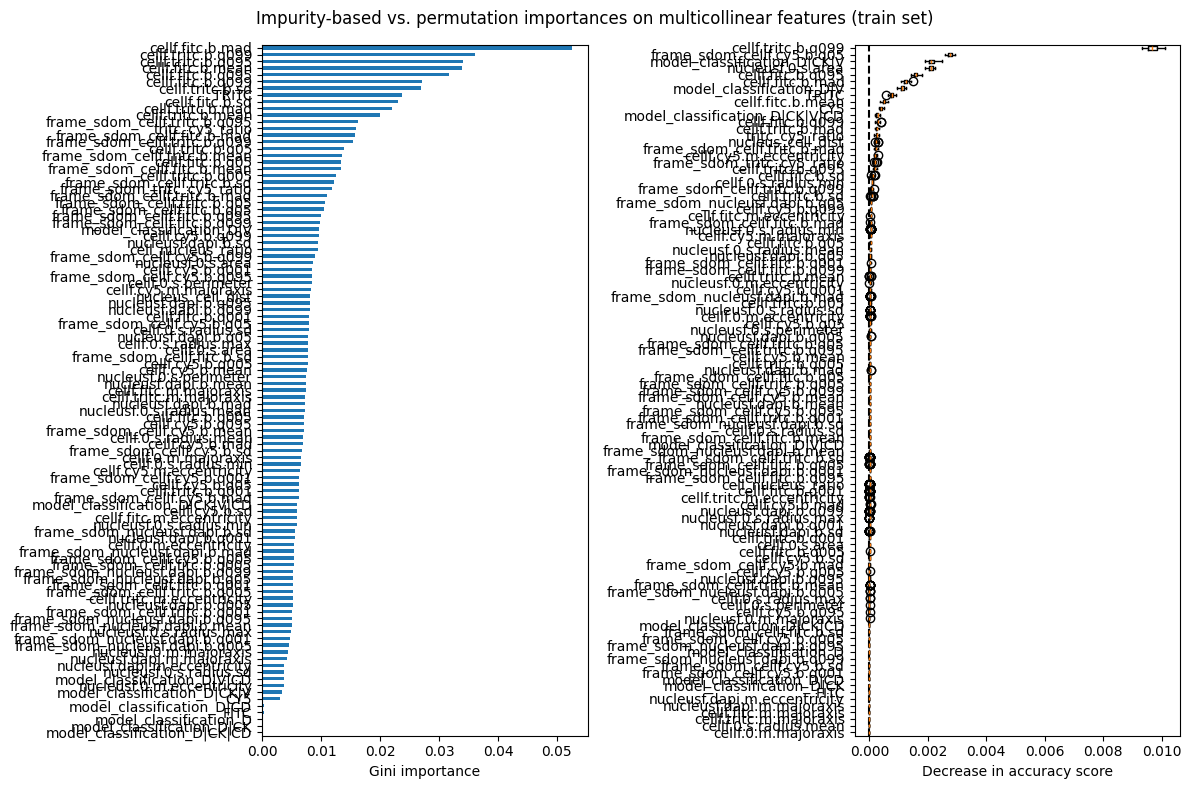

In [88]:
mdi_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(rf_clf.feature_importances_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(rf_clf,
                             X_res,
                               y_res,
                                 ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()

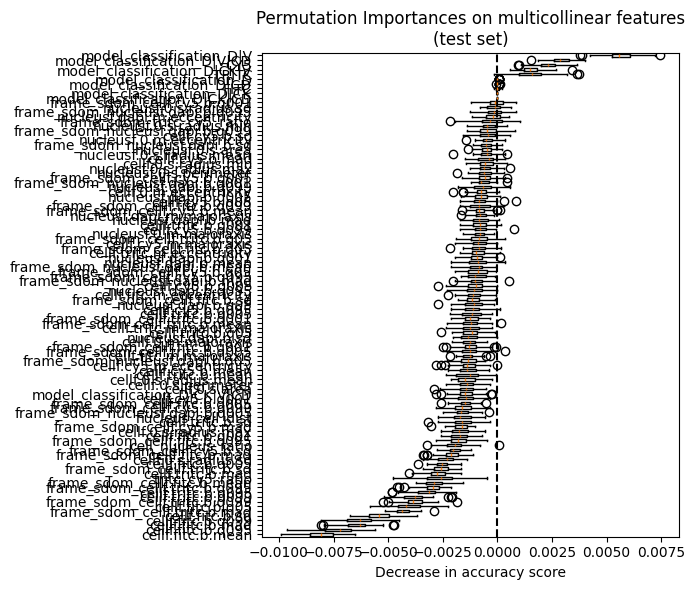

In [89]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(rf_clf,
                             X_val,
                             y_val, ax)
ax.set_title("Permutation Importances on multicollinear features\n(val set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

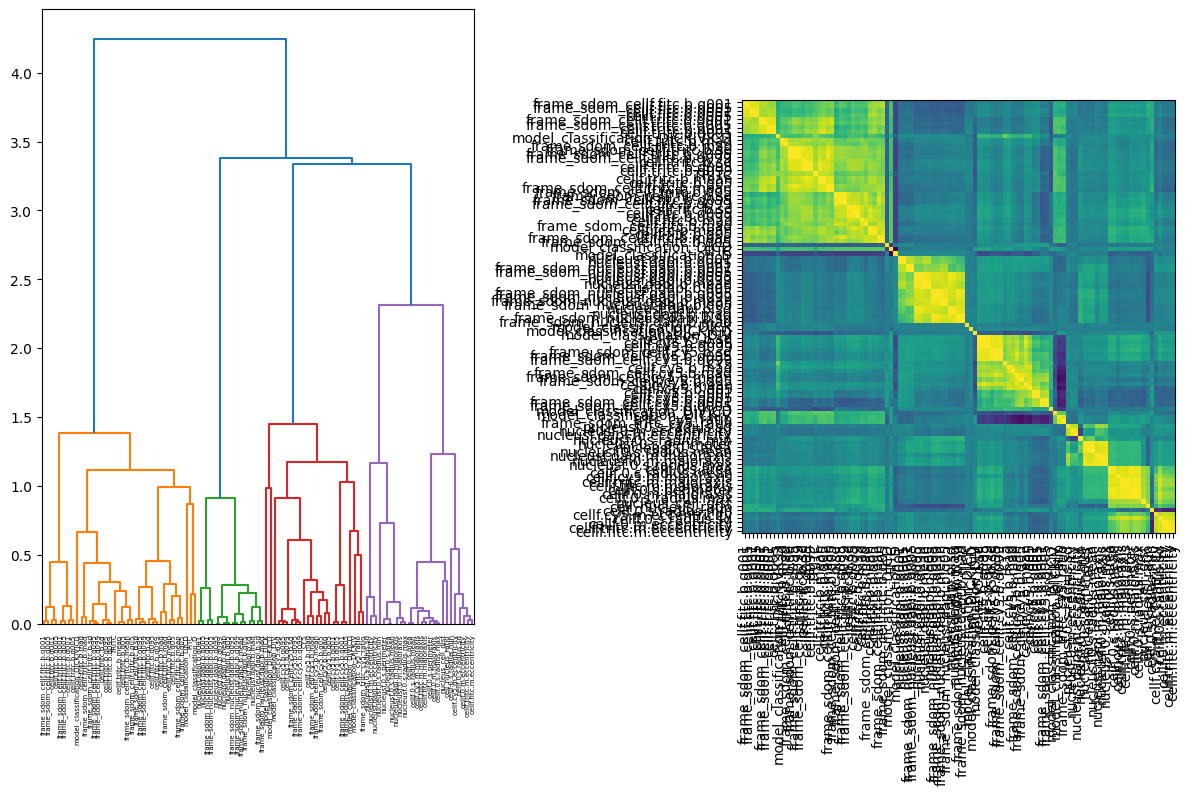

In [90]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_res).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_res.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [93]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X_train.columns[selected_features]

X_train_sel = X_res[selected_features_names]
X_val_sel = X_val[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_res)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_val_sel, y_val):.2}"
)

Baseline accuracy on test data with features removed: 0.84


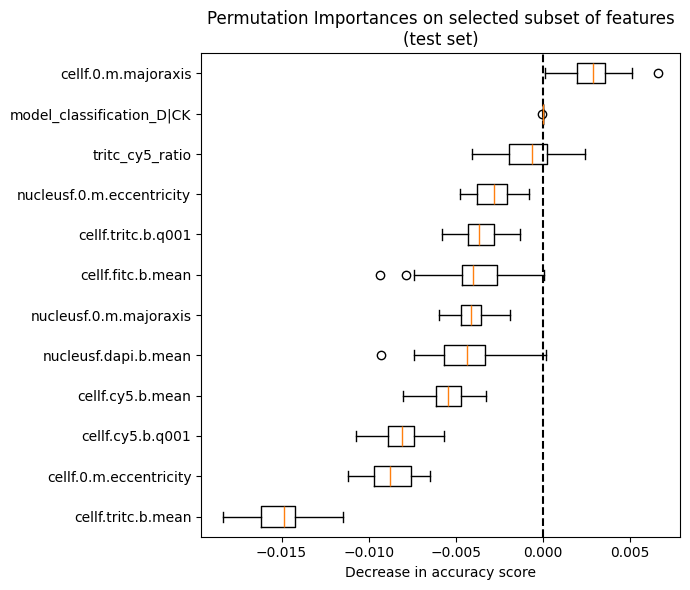

In [94]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_val_sel, y_val, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

In [95]:
# Fit the model to the resampled dataset
classifier_res = HistGradientBoostingClassifier(class_weight='balanced',
                                             validation_fraction=0.1,
                                               random_state=42)
classifier_res.fit(X_train_sel, y_res)

print(
    "Baseline accuracy with model(Hist Gradient Boosting Classifier) trained on all features: "
    f" {classifier_res.score(X_val_sel, y_val):.2}"
)


Baseline accuracy with model(Hist Gradient Boosting Classifier) trained on all features:  0.78
